<a href="https://colab.research.google.com/github/profedaniel86/Series_de_Tiempo/blob/main/1.Intro/Suavizaci%C3%B3n_exponencial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamentos de analítica 2 -Aprendizaje Automatico III (clase 1)

## Diego Fernando Agudelo - Daniel Felipe Osorio
## Universidad ICESI
## diegoagudelo30@gmail.com - dfosorio@icesi.edu.co


## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

train_len_local = 207
test_len_local = 15


Este documento presenta una breve introducción a la construcción de objetos de series de tiempo y el cálculo de pronósticos con modelos de suavización.

Para este ejercicio emplearemos la información disponible en el archivo datosEmpleo.xlsx. En ese archivo econtrarán la tasa de desempleo mensual de las 13 principales ciudades en Colombia (TD_13ciudades). El archivo también contiene series mensuales para las 13 principales ciudades de Colombia el número de ocupados en miles de personas (Ocupados), los desocupados (Desocupados) y los inactivos (Inactivos).

## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


En este caso los datos fueron leídos como un data frame y adicionalmente la columna "mes" fue seleccionada como indice, con el dataframe de esta forma sera más facil trabajar las series de tiempo.

A continuación se gráfica la tasa de desempleo.



(222, 4)


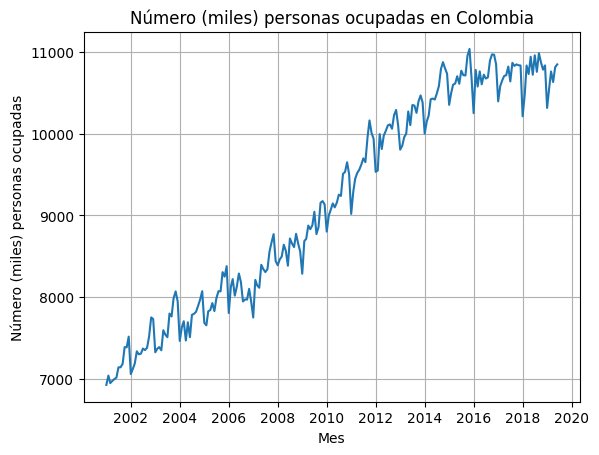

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Número (miles) personas ocupadas en Colombia")
plt.xlabel("Mes")
plt.ylabel("Número (miles) personas ocupadas")
plt.plot(data[["Ocupados"]])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

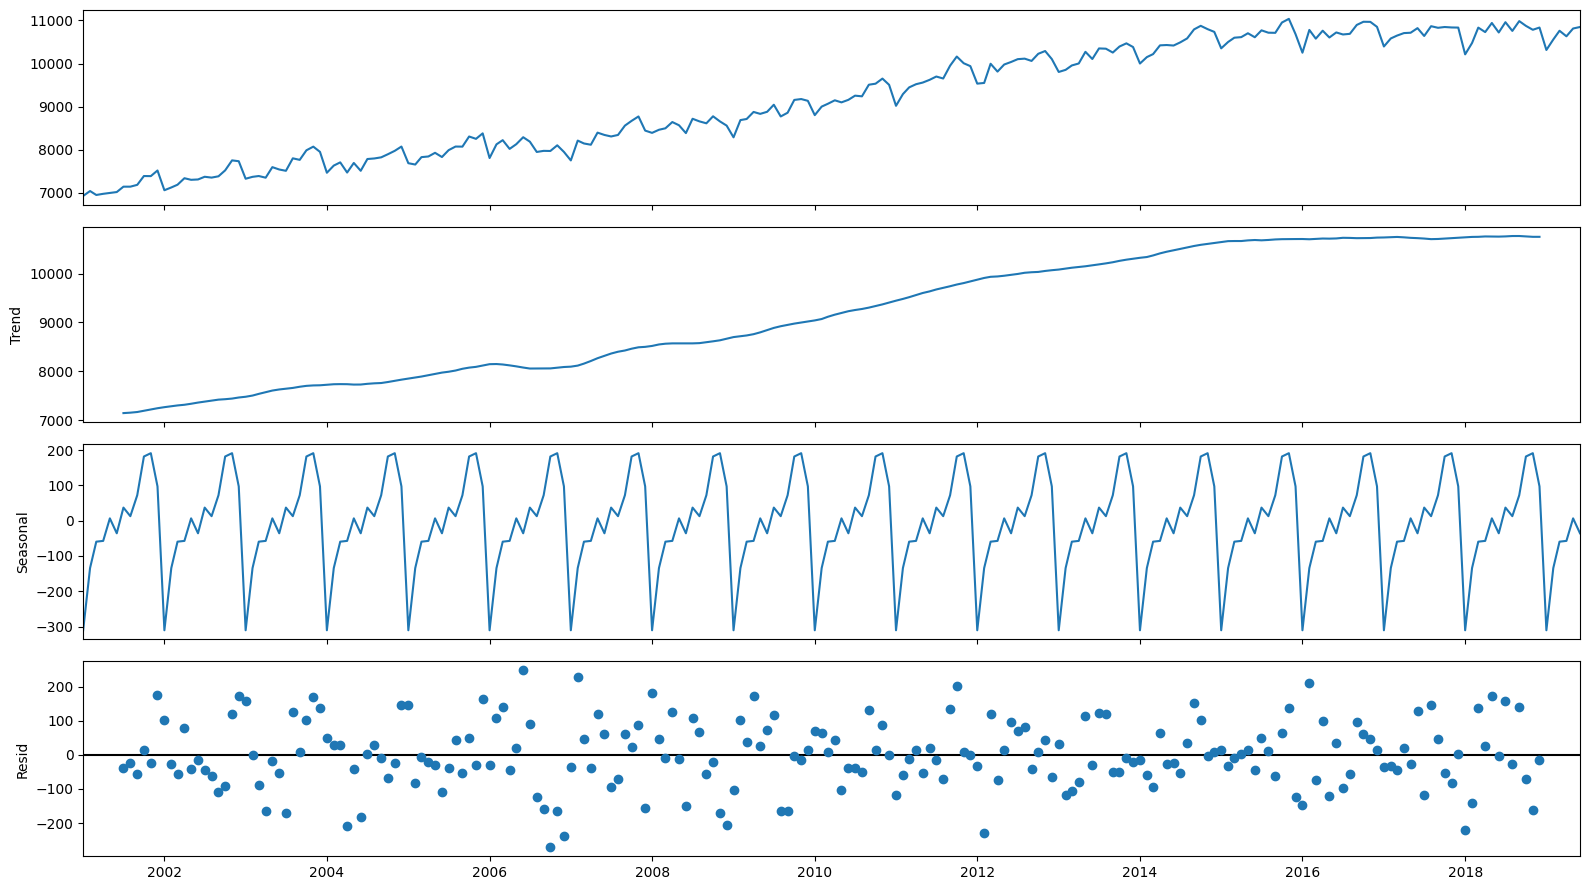

In [4]:
ocuppied_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = ocuppied_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [5]:
ocuppied_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

mes
2001-01-01   -310.570069
2001-02-01   -134.331549
2001-03-01    -59.585841
2001-04-01    -57.385905
2001-05-01      6.435912
                 ...    
2019-02-01   -134.331549
2019-03-01    -59.585841
2019-04-01    -57.385905
2019-05-01      6.435912
2019-06-01    -35.859993
Name: seasonal, Length: 222, dtype: float64

Podemos observar el componente estacional marcado en la serie, una tendencia no lineal de los datos y la parte aleatoria.

Es importante mencionar que esta descomposición se emplea solo como referencia para iniciar el análisis.

Antes de entrar a trabajar con los métodos de suavizamiento, vale la pena anotar que una forma sencilla y rápida para quitar el componente estacional (desestacionalizar) es restarle a la serie el componente estacional encontrado en la descomposición. Es decir,

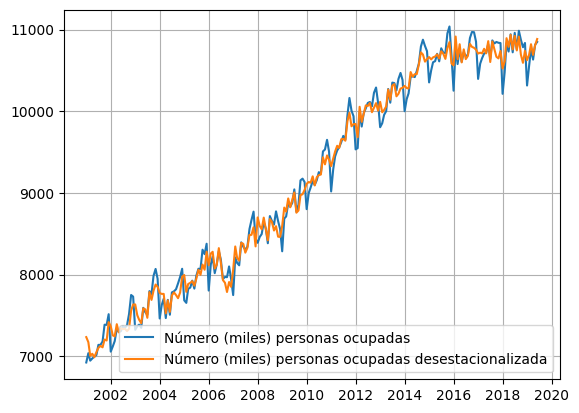

In [6]:
ocuppied_desestacionalizada = data["Ocupados"]-ocuppied_componentes.seasonal

plt.plot(data[["Ocupados"]],label="Número (miles) personas ocupadas")
plt.plot(ocuppied_desestacionalizada,label="Número (miles) personas ocupadas desestacionalizada")
plt.legend()
plt.grid()
plt.show()


## **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

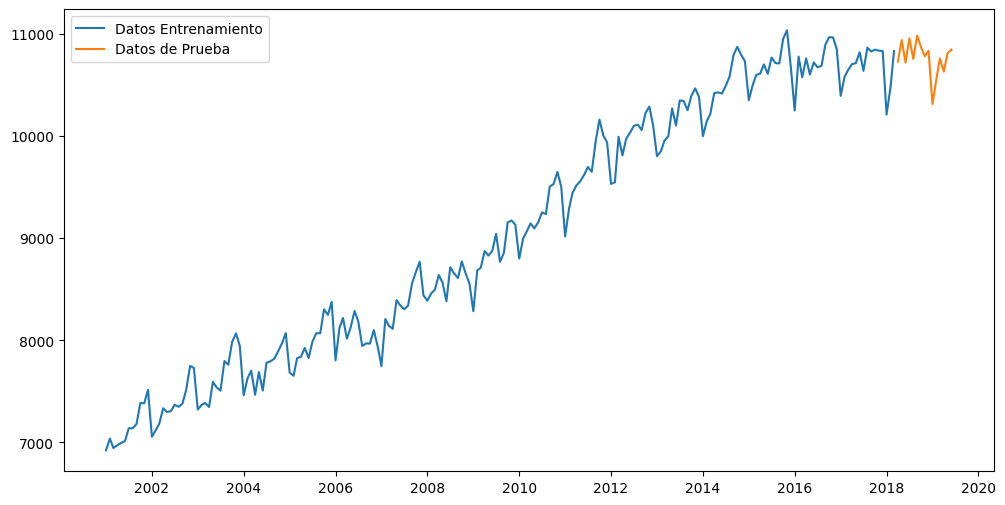

In [7]:
train_len = train_len_local
train_ocuppied = data[["Ocupados"]][:train_len]
test_ocuppied = data[["Ocupados"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocuppied,label="Datos Entrenamiento")
plt.plot(test_ocuppied,label="Datos de Prueba")
plt.legend()
plt.show()

In [8]:
train_ocuppied

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2017-11-01,10837.443
2017-12-01,10834.330
2018-01-01,10212.612


In [9]:
test_ocuppied

,Ocupados
mes,
2018-04-01,10729.977
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398


### **4.1 Promedio movil**

El promedio móvil está dado por:

$$ F_{t + 1}=\frac{Y_{t} + Y_{t-1} + Y_{t-(k-1)} }{ k} $$

El método de los promedios móviles utiliza el promedio de los $k$
valores de datos más recientes en la serie de tiempo como el
pronóstico para el siguiente periodo.

El término móvil indica que, mientras se dispone de una nueva
observación para la serie de tiempo, reemplaza a la observación más
antigua de la ecuación anterior y se calcula un promedio nuevo.
Como resultado, el promedio cambiará, o se moverá, conforme surjan
nuevas observaciones.

$Y_{t}$ = Observación en el período t

$F_{t}$ = Pronóstico en el período t

In [10]:
## Considerando el dato actual
ma_2= train_ocuppied.rolling(2,min_periods=2).mean()
ma_3= train_ocuppied.rolling(3,min_periods=2).mean()
ma_4= train_ocuppied.rolling(4,min_periods=2).mean()
ma_5= train_ocuppied.rolling(5,min_periods=2).mean()
ma_6= train_ocuppied.rolling(6,min_periods=2).mean()

In [11]:
## Sin considerar el dato actual
ma_2= train_ocuppied.shift().rolling(2,min_periods=2).mean()
ma_3= train_ocuppied.shift().rolling(3,min_periods=2).mean()
ma_4= train_ocuppied.shift().rolling(4,min_periods=2).mean()
ma_5= train_ocuppied.shift().rolling(5,min_periods=2).mean()
ma_6= train_ocuppied.shift().rolling(6,min_periods=2).mean()


In [12]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [13]:
ma_2_f= fore_ma(train_ocuppied,2,test_len_local)
ma_3_f= fore_ma(train_ocuppied,3,test_len_local)
ma_4_f= fore_ma(train_ocuppied,4,test_len_local)
ma_5_f= fore_ma(train_ocuppied,5,test_len_local)
ma_6_f= fore_ma(train_ocuppied,6,test_len_local)

In [14]:
test_ocuppied

,Ocupados
mes,
2018-04-01,10729.977
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338
2018-11-01,10783.299
2018-12-01,10835.398


In [15]:
ma_2_f

,Ocupados
mes,
2018-04-01,10655.145500
2018-05-01,10744.562750
2018-06-01,10699.854125
2018-07-01,10722.208437
2018-08-01,10711.031281
2018-09-01,10716.619859
2018-10-01,10713.825570
2018-11-01,10715.222715
2018-12-01,10714.524143


In [16]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_ocuppied,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_ocuppied,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_ocuppied,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_ocuppied,ma_5_f ))
rmse_ma_6 = np.sqrt(mean_squared_error(test_ocuppied,ma_6_f ))

In [17]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5, rmse_ma_6 )

171.52135250398018 234.04695802295464 239.58087070986656 228.02614704782854 215.174489490054


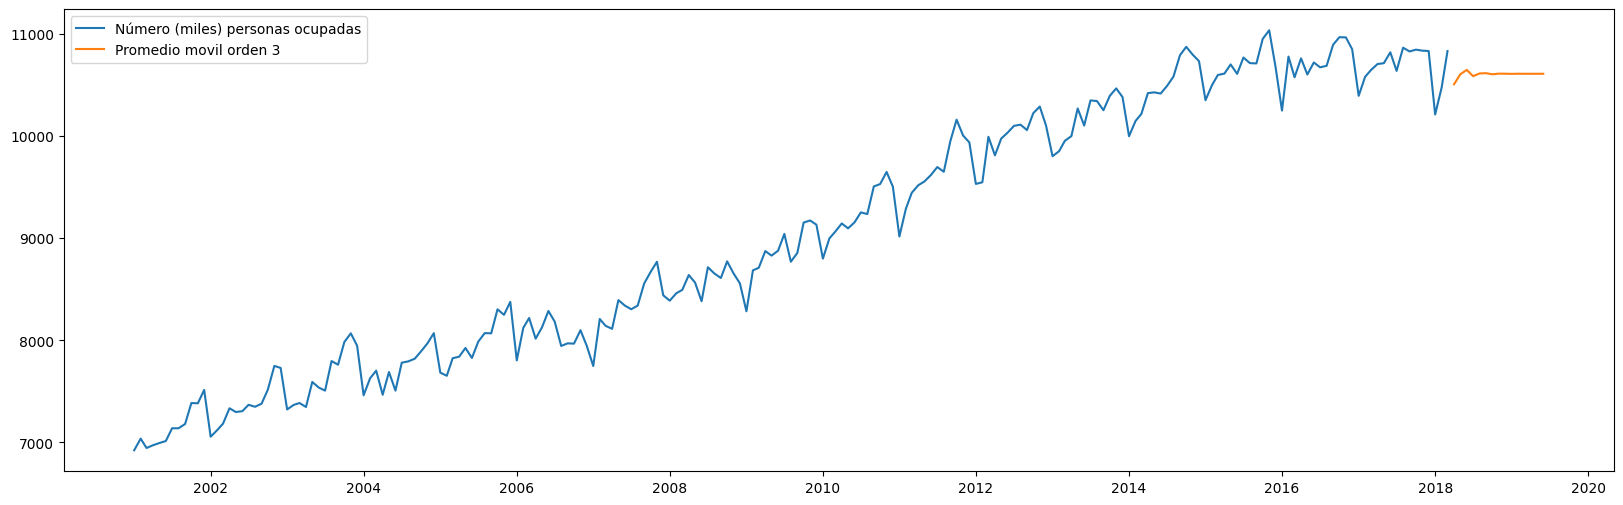

In [18]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_ocuppied,label="Número (miles) personas ocupadas")
plt.plot(ma_3_f,label="Promedio movil orden 3")
plt.legend()
plt.show()

### **4.2 Suavizacion Exponencial Simple**

In [19]:
data.columns

Index(['TD_13ciudades', 'Ocupados', 'Desocupados', 'Inactivos'], dtype='object')

In [20]:
# Build model.
ets_model = ETSModel(endog=train_ocuppied["Ocupados"],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(test_len_local)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-04-01     10701.98987  10344.463457  11059.516284
2018-05-01     10701.98987  10276.327015  11127.652726
2018-06-01     10701.98987  10217.683567  11186.296174
2018-07-01     10701.98987  10165.411521  11238.568220
2018-08-01     10701.98987  10117.798074  11286.181667
2018-09-01     10701.98987  10073.783070  11330.196671
2018-10-01     10701.98987  10032.656236  11371.323505
2018-11-01     10701.98987   9993.914138  11410.065603
2018-12-01     10701.98987   9957.184545  11446.795196
2019-01-01     10701.98987   9922.183034  11481.796707
2019-02-01     10701.98987   9888.686463  11515.293278
2019-03-01     10701.98987   9856.515943  11547.463798
2019-04-01     10701.98987   9825.525444  11578.454297
2019-05-01     10701.98987   9795.593919  11608.385822
2019-06-01     10701.98987   9766.619703  11637.360038


c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


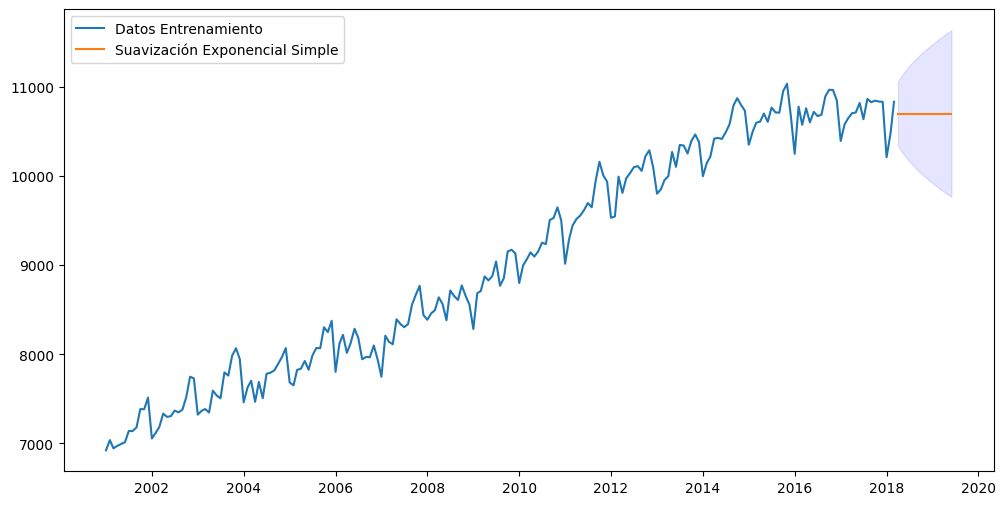

In [21]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocuppied,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.648279.Y el RMSE en la muestra de evaluación es 169.19

In [22]:
ets_result.alpha

np.float64(0.6461226333967518)

In [23]:
rmse = np.sqrt(mean_squared_error(test_ocuppied,point_forecast ))
print(rmse)

177.8912880624391


### **4.3 Suavizacion Exponencial Lineal (Holt)**

In [24]:
# Build model.
ets_model = ETSModel(endog=train_ocuppied["Ocupados"],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(test_len_local)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-04-01    10720.621686  10343.877648  11140.332920
2018-05-01    10744.211844  10296.868026  11208.339181
2018-06-01    10767.853911  10264.648966  11314.859212
2018-07-01    10791.548001  10244.168194  11406.873719
2018-08-01    10815.294228  10229.146878  11455.990688
2018-09-01    10839.092708  10182.353171  11564.120046
2018-10-01    10862.943555  10167.699940  11622.703608
2018-11-01    10886.846885  10147.590217  11731.658715
2018-12-01    10910.802812  10152.754489  11767.151785
2019-01-01    10934.811454  10150.221603  11781.450640
2019-02-01    10958.872925  10136.189705  11837.148072
2019-03-01    10982.987342  10131.270540  11903.363724
2019-04-01    11007.154821  10171.121895  11915.730195
2019-05-01    11031.375480  10141.655598  12060.311917
2019-06-01    11055.649435  10070.609844  12110.531197


c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


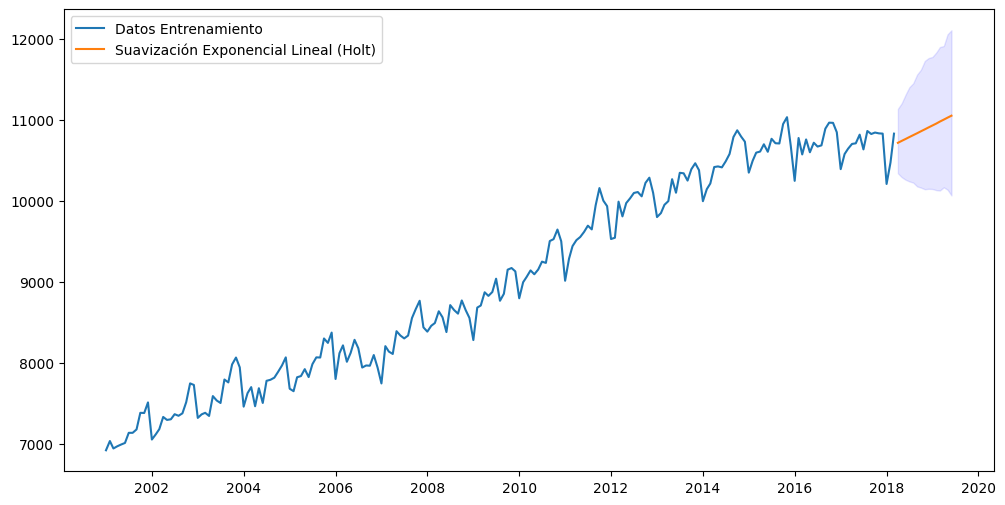

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocuppied,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.5619343685836977 y el β estimado es 5.619343685836977e$^{-5}$. Y el RMSE en la muestra de evaluación es ??????.

In [26]:
print(ets_result.alpha,ets_result.beta)

0.5617587672001219 5.617587672001219e-05


In [27]:
rmse_holt = np.sqrt(mean_squared_error(test_ocuppied,preds_holt['Point_forecast']))
print(rmse_holt)

249.93305241181656


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [28]:
# Build model
ets_model = ETSModel(endog=train_ocuppied["Ocupados"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(test_len_local)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-04-01    10723.544938  10501.010268  10946.079607
2018-05-01    10801.138745  10549.999918  11052.277572
2018-06-01    10784.051710  10507.244103  11060.859316
2018-07-01    10862.261020  10561.966328  11162.555712
2018-08-01    10867.778628  10545.700900  11189.856357
2018-09-01    10938.545795  10596.063775  11281.027816
2018-10-01    11079.000324  10717.259372  11440.741277
2018-11-01    11117.151173  10737.122476  11497.179869
2018-12-01    11027.065904  10629.586578  11424.545231
2019-01-01    10636.170158  10221.971496  11050.368819
2019-02-01    10833.510974  10403.239015  11263.782934
2019-03-01    10921.698972  10475.929862  11367.468081
2019-04-01    10931.437238  10470.686301  11392.188174
2019-05-01    11009.031044  10533.770073  11484.292016
2019-06-01    10991.944009  10502.600297  11481.287721


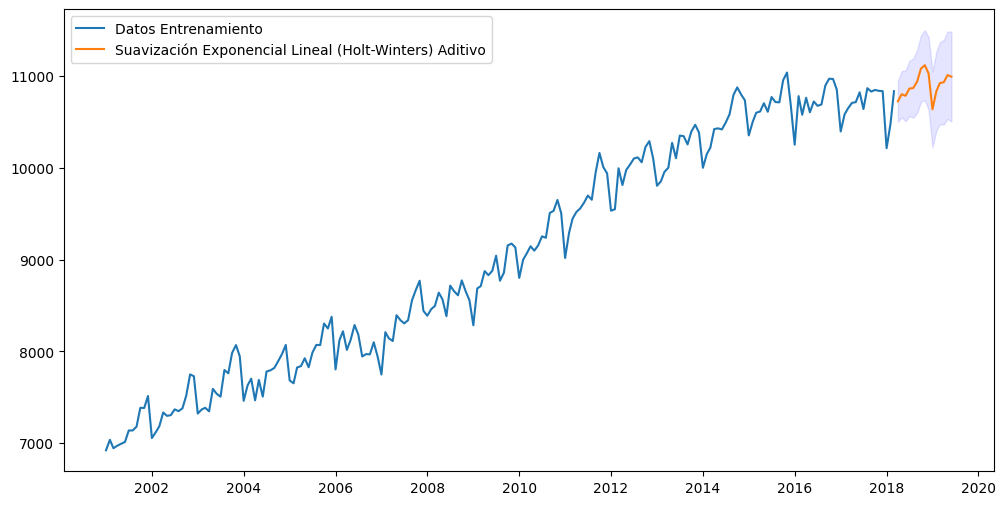

In [29]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocuppied,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [30]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.5230136378889441 5.230136378889441e-05 4.76986362111056e-05


In [31]:
rmse_hw_add = np.sqrt(mean_squared_error(test_ocuppied,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

198.6235351232173


In [32]:
# Build model.
ets_model = ETSModel(endog=train_ocuppied["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(test_len_local)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-04-01    10732.067410  10510.070017  10946.546355
2018-05-01    10788.718725  10519.686249  11040.650748
2018-06-01    10758.324120  10459.960335  11041.900705
2018-07-01    10833.348324  10479.261713  11145.397035
2018-08-01    10817.783162  10469.172989  11133.584065
2018-09-01    10879.804543  10484.846902  11257.042002
2018-10-01    11023.040282  10603.059798  11443.966738
2018-11-01    11037.883033  10587.429972  11482.830950
2018-12-01    10911.757792  10437.059967  11368.117588
2019-01-01    10435.636260   9957.124789  10896.829735
2019-02-01    10639.225972  10140.029008  11130.675202
2019-03-01    10722.940581  10210.956398  11231.046933
2019-04-01    10732.067410  10205.221346  11266.573123
2019-05-01    10788.718725  10194.928209  11305.875773
2019-06-01    10758.324120  10169.944065  11290.346477


c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


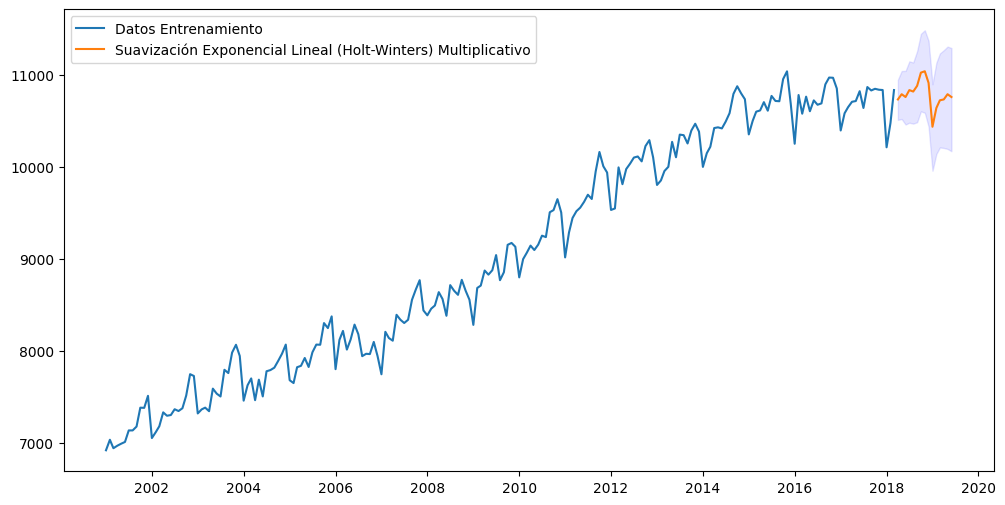

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocuppied,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [34]:
print(ets_result.alpha,ets_result.gamma)

0.6068959290175995 3.9310407098240055e-05


In [35]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_ocuppied,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

112.3737248665559


In [36]:
preds_hw_mul

,Point_forecast,lower_95,upper_95
2018-04-01,10732.067410,10510.070017,10946.546355
2018-05-01,10788.718725,10519.686249,11040.650748
2018-06-01,10758.324120,10459.960335,11041.900705
2018-07-01,10833.348324,10479.261713,11145.397035
2018-08-01,10817.783162,10469.172989,11133.584065
2018-09-01,10879.804543,10484.846902,11257.042002
2018-10-01,11023.040282,10603.059798,11443.966738
2018-11-01,11037.883033,10587.429972,11482.830950
2018-12-01,10911.757792,10437.059967,11368.117588
2019-01-01,10435.636260,9957.124789,10896.829735


## **5. Ejercicio en Clase**

Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

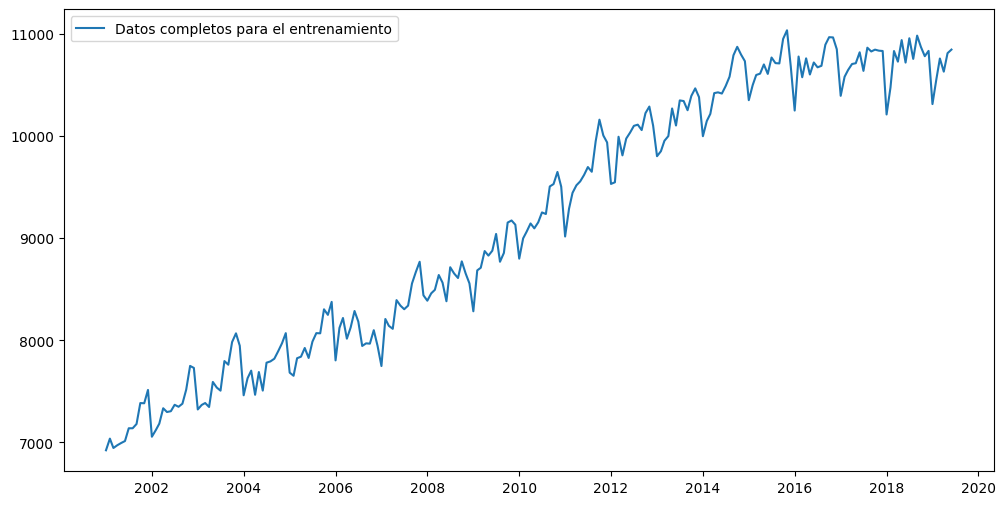

In [37]:
train_ocuppied_final = data[["Ocupados"]]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_ocuppied_final,label="Datos completos para el entrenamiento")
plt.legend()
plt.show()

In [38]:
#Modelo seleccionado final
# Build model.
ets_model = ETSModel(endog=train_ocuppied_final["Ocupados"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

#forecast para los próximos 6 meses
point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2019-07-01    10890.476734  10660.080597  11115.733030
2019-08-01    10860.094959  10623.220057  11122.767243
2019-09-01    10934.972152  10658.823946  11237.654026
2019-10-01    11059.017257  10721.430868  11388.488164
2019-11-01    11065.791357  10714.038306  11428.311690
2019-12-01    10952.267361  10561.924677  11322.758752


c:\Personal\Sebas\Universidades\ICESI\Maestrias\InteligenciaArtificialAplicada\Aprendizaje Automatico III\Notebooks\env-AA3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [39]:
conf_forecast

,lower PI (alpha=0.050000),upper PI (alpha=0.050000)
2019-07-01,10660.080597,11115.733030
2019-08-01,10623.220057,11122.767243
2019-09-01,10658.823946,11237.654026
2019-10-01,10721.430868,11388.488164
2019-11-01,10714.038306,11428.311690
2019-12-01,10561.924677,11322.758752


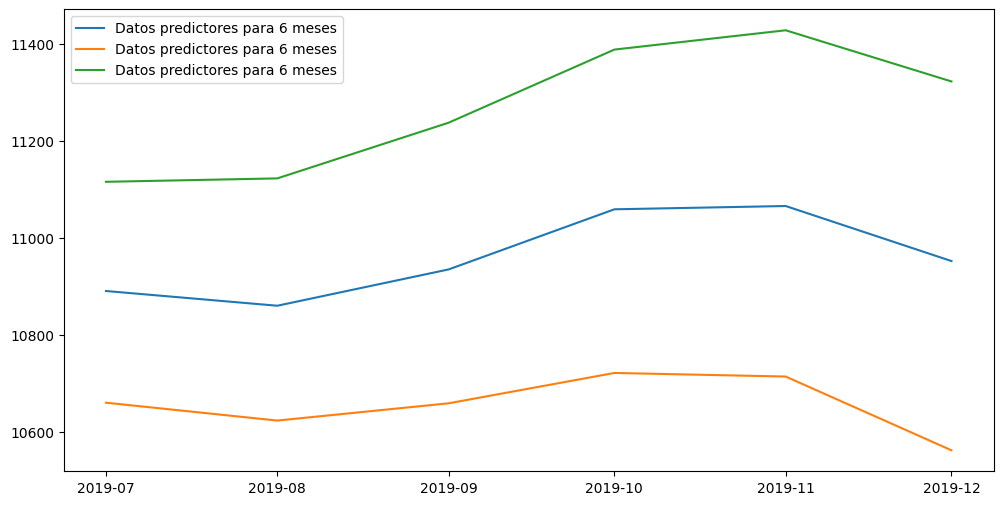

In [40]:
fig = plt.figure(figsize=(12, 6))
plt.plot(preds_hw_mul,label="Datos predictores para 6 meses")
plt.legend()
plt.show()